In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer , scale, LabelEncoder, StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint  # Réimporte la classe au cas où elle a été écrasée
from dataVisualisation import viewData, viewDataDistribution

In [9]:
datapath = 'dataSetAugmented'

Type de data : <class 'dict'>
{
    "Images\\augmentedA_frame_1080.jpg": {
        "landmarks": [
            [
                0.4106391370296478,
                0.4299352765083313,
                0.18186531960964203,
                0.9866544604301453
            ],
            [
                0.40995359420776367,
                0.4163743257522583,
                0.15403801202774048,
                0.983625590801239
            ],
            [
                0.40927648544311523,
                0.41638150811195374
Nombre total d'images : 1640
Répartition des labels :
blocage_gauche: 410 images
coup_de_poing_droit: 410 images
coup_de_poing_gauche: 410 images
blocage_droit: 410 images


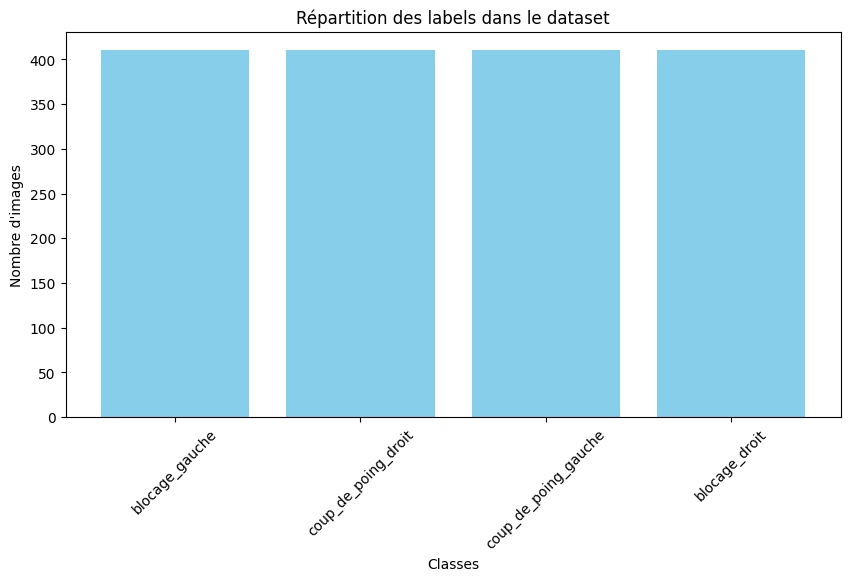

In [10]:
viewData(datapath)
viewDataDistribution(datapath)

In [12]:
with open(datapath, "r") as f:
    data = json.load(f)

all_features = []
all_labels = []

for image_name, infos in data.items():
    landmarks = infos["landmarks"]
    label = infos["label"]

    all_features.append(np.array(landmarks).flatten())
    all_labels.append(label)


train_features, test_features, train_label, test_label = train_test_split(
    all_features,all_labels,test_size=0.3,random_state=42,stratify=all_labels
)

lb = LabelBinarizer()

y_train = lb.fit_transform(train_label)
y_test = lb.transform(test_label)

X_train = np.array(train_features)
X_test = np.array(test_features)

scaler = MinMaxScaler()

x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

In [13]:
print(y_train[:10])  # Vérifie combien de classes il y a

[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]]


In [14]:
# Vérifions que les labels sont bien entre 0 et 1 =>

print(np.unique(y_train))  # Doit afficher [0 1]
print(np.unique(y_test))   # Doit afficher [0 1]

[0 1]
[0 1]


In [15]:
#Building the MLP model =>
model = Sequential([
    Dense(128, activation='relu',input_shape=(132,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])

# Model compilation =>
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resume
model.summary()

c:\Users\djibr\Documents\cours\m1P8\S2\projetAmmi\AmiEnv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,492 (107.39 KB)

 Trainable params: 27,492 (107.39 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpoint_callback = ModelCheckpoint(
    filepath="modelMLPAugmented.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [18]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint_callback])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2708 - loss: 1.4037 - val_accuracy: 0.3841 - val_loss: 1.3463
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3225 - loss: 1.3423 - val_accuracy: 0.4065 - val_loss: 1.3018
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3774 - loss: 1.3168 - val_accuracy: 0.5102 - val_loss: 1.2386
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4102 - loss: 1.2654 - val_accuracy: 0.4593 - val_loss: 1.2175
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4253 - loss: 1.2628 - val_accuracy: 0.5264 - val_loss: 1.1470
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4712 - loss: 1.1642 - val_accuracy: 0.5203 - val_loss: 1.1455
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4825 - loss: 1.1664 - val_accuracy: 0.5346 - val_loss: 1.0731
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5126 - loss: 1.0994 - val_accuracy: 0.5224 - val_loss:

In [19]:
from tensorflow.keras.models import load_model

# Charger le meilleur modèle sauvegardé
best_model = load_model("modelMLPAugmented.keras")

# Évaluer le modèle sur les données de test
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy (best model):", test_accuracy)

Test Accuracy (best model): 0.7886179089546204


Text(0.5, 1.0, 'Évolution de la perte')

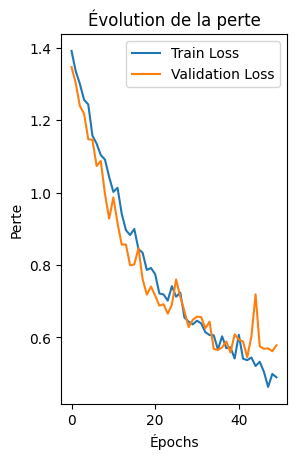

In [20]:
# Courbe de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Épochs")
plt.ylabel("Perte")
plt.legend()
plt.title("Évolution de la perte")

Text(0.5, 1.0, 'Évolution de la précision')

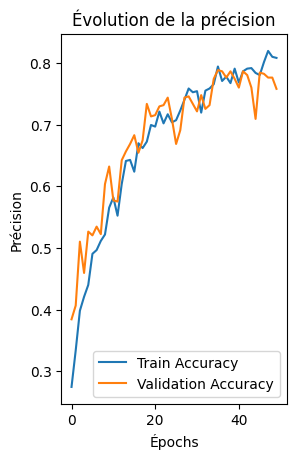

In [21]:
# Courbe de la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Épochs")
plt.ylabel("Précision")
plt.legend()
plt.title("Évolution de la précision")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.7886
Precision: 0.7905
Recall: 0.7886
F1-score: 0.7882


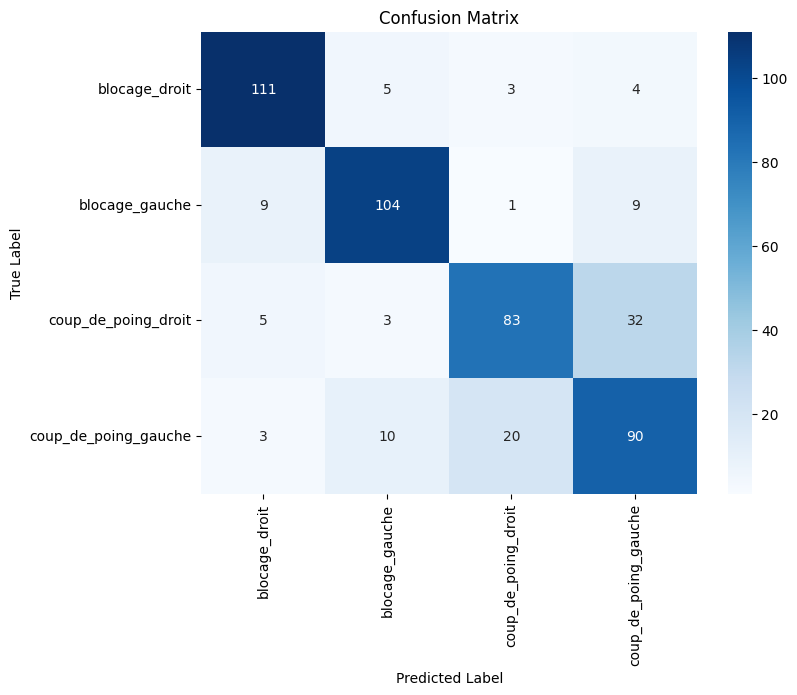

In [23]:
import time
import numpy as np
import psutil
import GPUtil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = load_model("modelMLPAugmented.keras")

# Prédictions du modèle
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcul des métriques
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
class_names = lb.classes_
# Matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
import time

# Mesurer le temps d'inférence pour une seule image
start_time = time.time()
model.predict(x_test[0:1])  # Prédire une seule image
end_time = time.time()
print(f"Temps d'inférence pour une image : {(end_time - start_time) * 1000:.2f} ms")

# Mesurer le temps d'inférence pour l'ensemble du dataset
start_time = time.time()
model.predict(x_test)  # Prédire toutes les images
end_time = time.time()
print(f"Temps d'inférence pour {len(x_test)} images : {end_time - start_time:.2f} s")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Temps d'inférence pour une image : 52.92 ms
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
Temps d'inférence pour 492 images : 0.06 s
